In [ ]:
import sys
!{sys.executable} -m pip install gym -U
!{sys.executable} -m pip install gym[box2D] -U
!{sys.executable} -m pip install flax -U

Imports

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np
import matplotlib.pyplot as plt
import optax                           # Optimizers
import pickle
from itertools import count

Simulator wrappers for convenience

In [ ]:
import gym

def _simulate_full_episode(agent, rm=None):
    """
        Simulate a full episode
    """
    # Sim init
    env = gym.make("LunarLander-v2", render_mode=rm)
    observation, info = env.reset()
    
    # Data init
    total_reward = 0
    observations = []
    actions = []
    rewards = []

    for i in count():
        # Simulate an episode
        action = agent.policy(observation)
        
        # Log the observation and action taken
        observations.append(observation)
        actions.append(action)
        
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Log the reward received, scaled to make value training easier
        rewards.append(reward * 0.01)

        total_reward += reward

        if terminated or truncated:
            break

    env.close()
    return observations, actions, rewards, total_reward, i+1

def visualize(agent, num_sim=1, rm="human"):
    """
        Wrapper to simulate an arbitrary number of episodes and fetch the reward
    """
    return [_simulate_full_episode(agent, rm)[3] for i in range(num_sim)]

def simulate(agent):
    return _simulate_full_episode(agent)

def evaluate_fitness(agent, eps=5):
    scores = [_simulate_full_episode(agent)[2] for i in range(5)]
    return np.mean(scores), np.median(scores)

Neural Networks

In [ ]:
class PGA_DNN(nn.Module):
    """
        PG Actor Approximator Function
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=4)(x)
        x = nn.softmax(x)
      
        return x

class PGV_DNN(nn.Module):
    """
        PG Value Approximator Function
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)

        return x

def init_model(model):
    """
        Semi-hardcoded init model
    """
    key1, key2 = random.split(random.PRNGKey(42))
    dummy_input = random.normal(key1, (8,))
    params = model.init(key2, dummy_input)
    
    return params

Model funcs

In [ ]:
class PG:
    def __init__(self, learning_rate=0.00025, vlearning_rate=0.002, gamma=0.99):
        actor_model = PGA_DNN()
        value_model = PGV_DNN()
        actor_param = init_model(actor_model)
        value_param = init_model(value_model)

        self.model = actor_model
        self.vmodel = value_model
        self.params = actor_param
        self.vparams = value_param

        self.optimizer = optax.adam(learning_rate)
        self.opt_state = self.optimizer.init(actor_param)

        self.voptimizer = optax.adam(vlearning_rate)
        self.vopt_state = self.optimizer.init(value_param)

        self.learning_rate = learning_rate
        self.vlearning_rate = vlearning_rate
        self.gamma = gamma

        def val_func(params, observations):
            return jnp.ravel(self.vmodel.apply(params, observations))
        self.val_func = val_func

        @jit
        def val_loss(params, observations, values):
            predict = val_func(params, observations)
            loss = jnp.mean(
                    optax.l2_loss(predict, values)
                )
            return loss, predict
        self.val_loss = val_loss
        self.val_grad = jax.value_and_grad(val_loss, has_aux=True)

        @jit
        def policy_func(params, observations):
            return  actor_model.apply(params, observations)
        self.policy_func = policy_func

        @jit
        def policy_loss(params, observations, actions, advantage, gamma_arr):
        # def policy_loss(params, observations, actions, advantage):
            probs = policy_func(params, observations)
            sel_probs = jnp.take_along_axis(probs, jnp.expand_dims(actions, axis=1), axis=1)
            sel_probs = jnp.ravel(sel_probs)
            loss_vec = jnp.log(sel_probs) * advantage * gamma_arr
            # loss_vec = jnp.log(sel_probs) * advantage
            # loss = -jnp.sum(loss_vec)
            loss = -jnp.mean(loss_vec)
            return loss, jnp.mean(sel_probs)
        self.policy_grad = jax.value_and_grad(policy_loss, has_aux=True)

    def train(self, observations, actions, rewards):
        n = len(observations)
        observations = jnp.array(observations)
        actions = jnp.array(actions)

        # Calculate the Gis
        g = []
        gi = 0
        for i in range(n-1,-1,-1):
            gi = gi * self.gamma + rewards[i]
            g.append(gi)
        g = jnp.array(g)

        # Get the value net prediction and gradient
        (vloss, predict), val_grad = self.val_grad(self.vparams, observations, g)
        advantage = g - predict
        # advantage = g - predict -0.1
        # advantage = g - predict +0.1
        # advantage = g - predict -0.4
        # advantage = g - predict +0.4
        # advantage = g - predict + jnp.array(np.random.normal(0, 0.125, n))
        # advantage = g - predict + jnp.array(np.random.normal(0, 0.5, n))

        vupdates, self.vopt_state = self.voptimizer.update(val_grad, self.vopt_state, self.vparams)
        self.vparams = optax.apply_updates(self.vparams, vupdates)

        # Gamma scaling vs no gamma scaling
        gamma_arr = jnp.array([self.gamma ** i for i in range(n)])
        (loss, avg), actor_grad = self.policy_grad(self.params, observations, actions, advantage, gamma_arr)
        # (loss, avg), actor_grad = self.policy_grad(self.params, observations, actions, advantage)
        # print(avg)
        updates, self.opt_state = self.optimizer.update(actor_grad, self.opt_state, self.params)
        self.params = optax.apply_updates(self.params, updates)    
        return vloss, loss, avg 

    def policy(self, observation):
        probs = self.policy_func(self.params, observation)
        probs = np.array(probs)
        # Rounding err fix
        # for i in range(4):
        #   if probs[-i] + 1 - np.sum(probs) >= 0:
        #     probs[-i] += 1 - np.sum(probs)
        #     break
        # print(self.val_func(self.vparams, observation))
        # print(probs)
        choice = np.random.choice(4, 1, p=probs)
        # print(choice)
        return int(choice)

Training config

In [ ]:
agent = PG()

reward_data = []
eplen_data = []

i = 0

Start/Continue training

In [ ]:
end = i + 10000
avg_vl = 0
avg_l = 0
for i in range(i, end):
    observations, actions, rewards, total_reward, n = simulate(agent)
    vl, l, mp = agent.train(observations, actions, rewards)
    avg_vl+=vl
    avg_l+=l
    reward_data.append(total_reward)
    eplen_data.append(n)
    print(mp)
    if mp > 0.95:
        break
    if i%10 == 9:
        avg_reward = sum(reward_data[-10:])/10
        print (i//10, avg_reward, avg_vl/10, avg_l/10)
        avg_vl = 0
        avg_l = 0
        if avg_reward > 200:
            print("Found solution")
            break


Text(0, 0.5, 'Episode Reward')

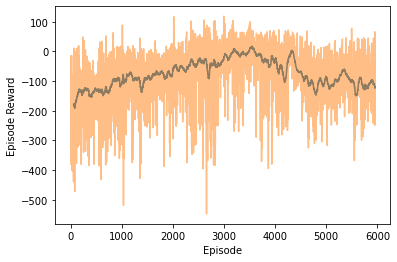

In [ ]:
def running_avg(stats):
    n = len(stats)
    gap = n//100
    avg_stats = [ sum(stats[i:min(n-1, i+gap)])/gap for i in range(n-gap)]
    return avg_stats

n = len(reward_data)
episode = [i for i in range(n)]
ar = running_avg(reward_data)
al = running_avg(eplen_data)
# plot rewards
plt.plot(episode[-len(ar):], ar)
plt.plot(episode, reward_data, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

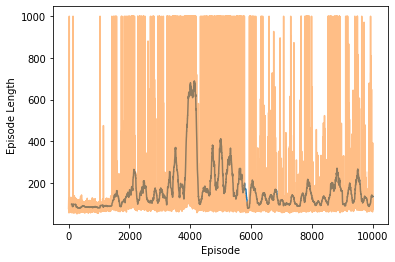

In [ ]:
# plot episode lengths
plt.plot(episode[-len(al):], al)
plt.plot(episode, eplen_data, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

Ep, Mean and var

In [ ]:
print(f"{i},{np.mean(reward_data[-100:])},{np.var(reward_data[-100:])}")
# print(f"{i},{np.mean(reward_data[8999:10000])},{np.var(reward_data[8999:10000])}")

5955,-112.27209479784382,3685.201964360591


In [ ]:
from IPython import display

env = gym.make("LunarLander-v2", render_mode='rgb_array')
obs, info = env.reset()

img = plt.imshow(env.render())

for i in range(5):
    while True:
        action = agent.policy(obs)
        obs, reward, done, done2, info = env.step(action)

        screen = env.render()
        img.set_data(screen)
        display.clear_output(wait=True)
        display.display(plt.gcf())

        if done:
            obs, info = env.reset()
            break
env.close()

An agent bank to store/load past trainings

In [ ]:
agent_bank = []

In [ ]:
agent_bank.append((agent, reward_data, eplen_data ))

In [ ]:
j = 0
agent, reward_data, eplen_data = agent_bank[j]

i = len(reward_data)

Stores the model and data to plot later and observe final behavior

In [ ]:
j=50
with open(f"/content/drive/MyDrive/pickle/pg_run{j}_data.pkl", "wb") as f:
    pickle.dump((reward_data, eplen_data), f)

# with open(f"/content/drive/MyDrive/pickle/pg_run{j}_model.pkl", "wb") as f:
#     pickle.dump((agent.params, agent.vparams, agent.learning_rate, agent.vlearning_rate, agent.gamma), f)

In [ ]:
j=50

# with open(f"/content/drive/MyDrive/pickle/pg_run{j}_model.pkl", "rb") as f:
#     _, _, learning_rate, vlearning_rate, gamma = pickle.load(f)

with open(f"/content/drive/MyDrive/pickle/pg_run{j}_data.pkl", "rb") as f:
    reward_data, eplen_data = pickle.load(f)

i = len(reward_data)

Stores and loads the agent to continue training

In [ ]:
with open(f"/content/drive/MyDrive/pickle/pg_run_resumable2.pkl", "wb") as f:
    pickle.dump((agent.params, agent.vparams, agent.opt_state, agent.vopt_state, agent.learning_rate, agent.vlearning_rate, agent.gamma), f)

In [ ]:
agent = PG()
# TODO: make this better
with open(f"/content/drive/MyDrive/pickle/pg_run_resumable2.pkl", "rb") as f:
    agent.params, agent.vparams, agent.opt_state, agent.vopt_state, agent.learning_rate, agent.vlearning_rate, agent.gamma = pickle.load(f)

In [ ]:
# mean, var and success percentage
def a():
    for i in range(30):
        if i > 0:
            x = reward_data[-1000*(i+1):-1000*i]
        else:
            x = reward_data[-1000:]
        x = np.array(x)
        mean = np.mean(x)
        var = np.var(x)
        sp = np.sum(x>200)/1000
        print(i, mean, var, sp)
    del x
a()